<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint


import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [106]:
class LoggingStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        obs, reward, terminated, truncated, info = super().step(actions)
        info["portfolio_value"] = self.asset_memory[-1]
        return obs, reward, terminated, truncated, info


<a id='1.4'></a>
## 2.4. Create Folders

In [83]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [84]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'

In [86]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TRADE_END_DATE,
                    ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
# yfp = YahooFinanceProcessor()
# df = yfp.download_data(['AXP', 'AMGN', 'AAPL'], '2010-01-01', '2010-02-01', '1m')
print(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (112073, 8)
Price         date       close        high         low        open     volume  \
0       2010-01-04    6.431897    6.446624    6.382909    6.414466  493729600   
1       2010-01-04   39.913246   40.016969   39.111109   39.159514    5277400   
2       2010-01-04   32.637955   32.781524   32.215226   32.550221    6894300   
3       2010-01-04   43.777538   43.941177   42.702190   43.419090    6186700   
4       2010-01-04   39.403473   39.834185   38.703564   38.797785    7325600   
...            ...         ...         ...         ...         ...        ...   
112068  2025-02-28  469.605164  470.989374  459.243337  461.734915    6146300   
112069  2025-02-28  362.108612  363.396482  353.123534  354.121876   15857300   
112070  2025-02-28   41.743721   42.382952   41.269142   42.063338   25197500   
112071  2025-02-28   10.680000   11.490000   10.480000   10.630000   52407400   
112072  2025-02-28   98.102753   98.351467   96.670158   97.286971   2545130

In [87]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [88]:
df.shape

(112073, 8)

In [89]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.431897,6.446624,6.382909,6.414466,493729600,AAPL,0
1,2010-01-04,39.913246,40.016969,39.111109,39.159514,5277400,AMGN,0
2,2010-01-04,32.637955,32.781524,32.215226,32.550221,6894300,AXP,0
3,2010-01-04,43.777538,43.941177,42.702190,43.419090,6186700,BA,0
4,2010-01-04,39.403473,39.834185,38.703564,38.797785,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [90]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (3812, 8)


Successfully added vix
Successfully added turbulence index


In [91]:
print(processed)

              date       close        high         low        open     volume  \
0       2010-01-04    6.431897    6.446624    6.382909    6.414466  493729600   
1       2010-01-04   39.913246   40.016969   39.111109   39.159514    5277400   
2       2010-01-04   32.637955   32.781524   32.215226   32.550221    6894300   
3       2010-01-04   43.777538   43.941177   42.702190   43.419090    6186700   
4       2010-01-04   39.403473   39.834185   38.703564   38.797785    7325600   
...            ...         ...         ...         ...         ...        ...   
110543  2025-02-27  463.277344  470.040224  459.777246  460.914305    4216800   
110544  2025-02-27  355.150177  359.712607  351.096911  351.316547    7298100   
110545  2025-02-27   41.908375   42.053652   41.540332   41.724355   19212300   
110546  2025-02-27   11.230000   11.850000   11.190000   11.700000   18971100   
110547  2025-02-27   96.292122   97.535692   95.317160   95.406701   16431500   

         tic  day       mac

In [92]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [93]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.431897,6.446624,6.382909,6.414466,493729600.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,6.431897,6.431897,20.040001,0.0
1,2010-01-04,AMGN,39.913246,40.016969,39.111109,39.159514,5277400.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,39.913246,39.913246,20.040001,0.0
2,2010-01-04,AXP,32.637955,32.781524,32.215226,32.550221,6894300.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,32.637955,32.637955,20.040001,0.0
3,2010-01-04,BA,43.777538,43.941177,42.702190,43.419090,6186700.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,43.777538,43.777538,20.040001,0.0
4,2010-01-04,CAT,39.403473,39.834185,38.703564,38.797785,7325600.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,39.403473,39.403473,20.040001,0.0
5,2010-01-04,CRM,18.542519,18.718477,18.386387,18.490475,7906000.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,18.542519,18.542519,20.040001,0.0
6,2010-01-04,CSCO,16.158167,16.256333,15.713146,15.778591,59853700.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,16.158167,16.158167,20.040001,0.0
7,2010-01-04,CVX,42.603542,42.678985,42.118557,42.140109,10173800.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,42.603542,42.603542,20.040001,0.0
8,2010-01-04,DIS,27.475876,28.058464,27.304527,27.844277,13700400.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,27.475876,27.475876,20.040001,0.0
9,2010-01-04,GS,131.992020,132.884268,129.269507,129.681321,9135000.0,0.0,0.0,6.453185,6.42173,100.0,66.666667,100.0,131.992020,131.992020,20.040001,0.0


In [94]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [95]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

100311
10237


In [96]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3458,2023-09-29,UNH,489.152222,494.672516,488.773839,494.643412,3006200.0,4.0,4.758832,499.945950,450.959732,55.148634,128.373463,19.202214,475.052338,477.039837,17.52,57.508317
3458,2023-09-29,V,227.020615,230.001369,226.665293,229.813836,6045200.0,4.0,-3.066167,251.200594,224.032589,41.887466,-154.262894,36.909070,238.148424,237.149244,17.52,57.508317
3458,2023-09-29,VZ,28.312365,28.609378,28.277421,28.495813,19787600.0,4.0,-0.276669,30.421854,28.184128,41.243804,-137.570645,33.867316,29.353076,29.363413,17.52,57.508317
3458,2023-09-29,WBA,20.083014,20.254587,18.854915,18.963277,25663400.0,4.0,-1.050146,20.962601,18.592988,36.119169,-53.011613,26.754668,20.958936,23.656806,17.52,57.508317
3458,2023-09-29,WMT,52.213684,53.258414,51.972087,53.225766,18842400.0,4.0,0.139828,54.153628,52.232614,50.578492,-24.941299,17.468385,52.741928,52.075984,17.52,57.508317


In [97]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.259903,172.805189,169.464080,169.751602,52164500.0,0.0,-2.561662,183.575469,165.836037,45.243155,-87.977329,26.128931,176.566326,181.009779,17.610001,34.480829
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867168,261.151714,237.536320,59.425484,72.229010,31.542893,247.539646,237.412817,17.610001,34.480829
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052553,160.817392,143.761848,37.445502,-174.733595,36.526638,153.348369,158.819425,17.610001,34.480829
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480829
0,2023-10-02,CAT,262.851074,267.774933,261.419371,263.741058,1778200.0,0.0,-0.878848,277.101089,259.928766,51.346824,-69.196499,1.038574,268.083487,264.021851,17.610001,34.480829


In [98]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [99]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [107]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}



e_train_gym = LoggingStockTradingEnv(df=train, **env_kwargs)

## Environment for Training



In [108]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [113]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class ConstraintCallback(BaseCallback):
    def __init__(self, penalty_type='drawdown', max_drawdown=0.15, max_volatility=0.05, verbose=0):
        super().__init__(verbose)
        self.penalty_type = penalty_type
        self.max_drawdown = max_drawdown
        self.max_volatility = max_volatility
        self.returns = []

    def _on_step(self) -> bool:
        info = self.locals.get("infos", [{}])[0]
        reward = self.locals.get("rewards", [0])[0]

        if "portfolio_value" in info:
            self.returns.append(info["portfolio_value"])

        if len(self.returns) >= 2:
            returns_np = np.array(self.returns)
            if self.penalty_type == 'drawdown':
                peak = np.maximum.accumulate(returns_np)
                drawdown = (peak - returns_np) / peak
                max_dd = np.max(drawdown)
                if max_dd > self.max_drawdown:
                    self.locals["rewards"][0] -= 1.0
            elif self.penalty_type == 'volatility':
                vol = np.std(np.diff(returns_np) / returns_np[:-1])
                if vol > self.max_volatility:
                    self.locals["rewards"][0] -= 1.0
        return True


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [114]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent 3: PPO

In [115]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
# Attach constraint callback here
constraint_callback = ConstraintCallback(
    penalty_type='drawdown',  # or 'volatility'
    max_drawdown=0.15,        # adjust as needed
    verbose=1
)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
model_ppo.learn(
    total_timesteps=200000,  # Adjusted for longer training
    callback=constraint_callback,
    tb_log_name='ppo_constraint'
)

trained_ppo = model_ppo

-----------------------------
| time/              |      |
|    fps             | 69   |
|    iterations      | 1    |
|    time_elapsed    | 29   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 2           |
|    time_elapsed         | 60          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013468316 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0222      |
|    learning_rate        | 0.00025     |
|    loss                 | 33.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0203     |
|    std                  | 1           |
|    value_loss           | 122         |
----------------------------------

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [117]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [118]:
insample_risk_indicator.vix.describe()

,vix
count,3459.000000
mean,18.633854
std,7.150486
min,9.140000
25%,13.705000
50%,16.870001
75%,21.570000
max,82.690002


In [119]:
insample_risk_indicator.vix.quantile(0.996)

np.float64(54.89679946899445)

In [120]:
insample_risk_indicator.turbulence.describe()

,turbulence
count,3459.000000
mean,34.754942
std,42.349260
min,0.000000
25%,15.118497
50%,24.215430
75%,39.727019
max,652.503087


In [121]:
insample_risk_indicator.turbulence.quantile(0.996)

np.float64(263.5026845904692)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [122]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 55,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [123]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.259903,172.805189,169.464080,169.751602,52164500.0,0.0,-2.561662,183.575469,165.836037,45.243155,-87.977329,26.128931,176.566326,181.009779,17.610001,34.480829
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867168,261.151714,237.536320,59.425484,72.229010,31.542893,247.539646,237.412817,17.610001,34.480829
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052553,160.817392,143.761848,37.445502,-174.733595,36.526638,153.348369,158.819425,17.610001,34.480829
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480829
0,2023-10-02,CAT,262.851074,267.774933,261.419371,263.741058,1778200.0,0.0,-0.878848,277.101089,259.928766,51.346824,-69.196499,1.038574,268.083487,264.021851,17.610001,34.480829


In [124]:
trained_model = trained_ppo  # Make sure this matches your model variable

# ✅ Run prediction using DRLAgent's method
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model,
    environment=e_trade_gym
)

hit end!


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [125]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [126]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [127]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [128]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[172.26 , 252.198, 145.908, ...,  27.745,  20.246,  52.269],
       [170.921, 247.179, 141.584, ...,  27.937,  20.363,  51.939],
       [172.171, 251.374, 143.126, ...,  27.552,  20.128,  52.563],
       ...,
       [246.716, 312.865, 291.633, ...,  42.335,  11.38 ,  97.187],
       [240.045, 303.696, 294.377, ...,  41.821,  11.04 ,  95.705],
       [236.989, 303.141, 292.488, ...,  41.908,  11.23 ,  96.292]])

In [129]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

### Use PyPortfolioOpt

In [130]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [131]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1462.163,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.001,    0.   ,    0.   , 1366.308])

In [132]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [133]:
# ✅ PPO (Meta-PPO) Result
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns={'account_value': 'ppo_meta'}, inplace=True)

# ✅ MVO Result (ensure it's a DataFrame)
if isinstance(MVO_result, pd.Series):
    MVO_result = MVO_result.to_frame(name='mean var')
elif isinstance(MVO_result, pd.DataFrame):
    MVO_result.columns = ['mean var']

# ✅ Merge Meta-PPO with MVO
result = pd.merge(df_result_ppo, MVO_result, how='outer', left_index=True, right_index=True)

# ✅ Final columns and output
result.columns = ['ppo_meta', 'mean var']
print(result.head())
print("Final result comparison:\n", result)

# ✅ Save to CSV
result.to_csv("result_meta_ppo_vs_mvo.csv")


                ppo_meta      mean var
date                                  
2023-10-02  1.000000e+06  1.005879e+06
2023-10-03  9.996627e+05  9.929165e+05
2023-10-04  1.000046e+06  9.981442e+05
2023-10-05  1.000396e+06  1.000998e+06
2023-10-06  1.001108e+06  1.008246e+06
Final result comparison:
                 ppo_meta      mean var
date                                  
2023-10-02  1.000000e+06  1.005879e+06
2023-10-03  9.996627e+05  9.929165e+05
2023-10-04  1.000046e+06  9.981442e+05
2023-10-05  1.000396e+06  1.000998e+06
2023-10-06  1.001108e+06  1.008246e+06
...                  ...           ...
2025-02-21  1.560939e+06  1.263438e+06
2025-02-24  1.573579e+06  1.261625e+06
2025-02-25  1.575816e+06  1.280903e+06
2025-02-26  1.573533e+06  1.259473e+06
2025-02-27  1.578171e+06  1.261514e+06

[353 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

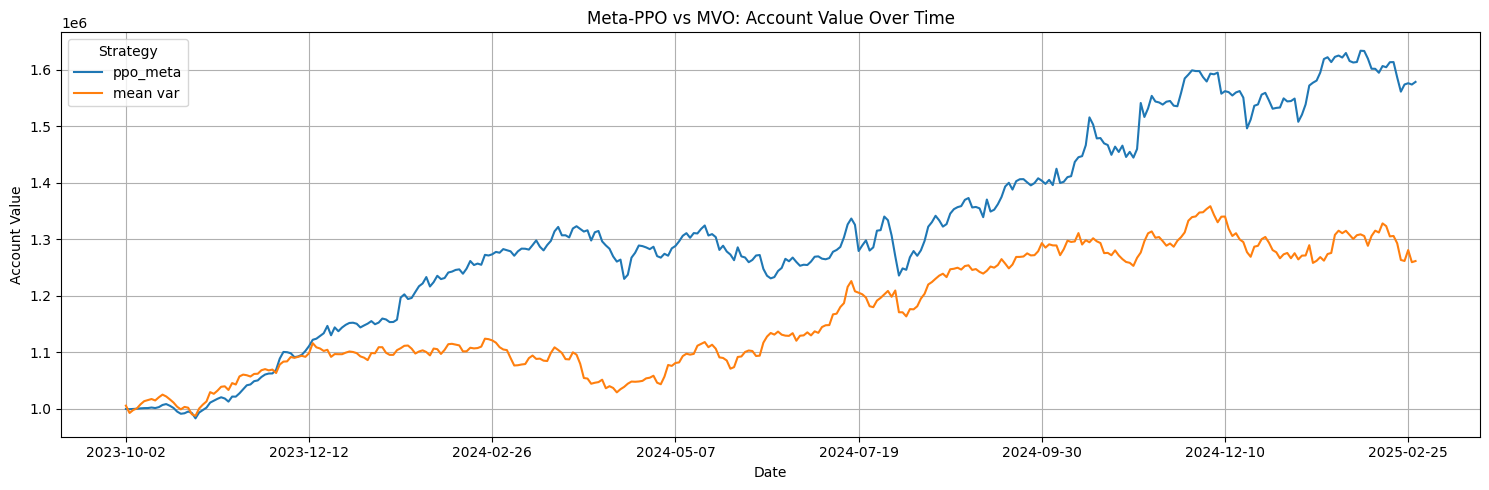

In [134]:
import matplotlib.pyplot as plt

# Ensure inline plotting for notebooks
%matplotlib inline

# Set figure size
plt.rcParams["figure.figsize"] = (15, 5)

# Plot the result DataFrame (Meta-PPO and MVO)
plt.figure()
result.plot(title='Meta-PPO vs MVO: Account Value Over Time')
plt.xlabel("Date")
plt.ylabel("Account Value")
plt.grid(True)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()


In [135]:
print("✅ Final Account Values:")
print(result.iloc[-1])


✅ Final Account Values:
ppo_meta    1.578171e+06
mean var    1.261514e+06
Name: 2025-02-27, dtype: float64
